In [1]:
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectFromModel

/home/akai/virtualenvs/tensor_flow/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/akai/virtualenvs/tensor_flow/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.info()
print('-'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

shapes2 (891, 11) (418, 11)


/home/akai/virtualenvs/tensor_flow/lib/python3.5/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


shapes1 (891, 14) (418, 14)
shapes4 (891, 15) (418, 15)
shapes5 (891, 10) (418, 10)
shapes (891, 56) (418, 56)
   Pclass     Fare  FamilySize  IsAlone  AgeBand  Sex_female  Sex_male  \
0       3   7.2500           2        0        1           0         1   
1       1  71.2833           2        0        2           1         0   
2       3   7.9250           1        1        1           1         0   
3       1  53.1000           2        0        2           1         0   
4       3   8.0500           1        1        2           0         1   

   Ticket_A4  Ticket_A5  Ticket_AS      ...        Cabin_U  Embarked_C  \
0          0          1          0      ...              1           0   
1          0          0          0      ...              0           1   
2          0          0          0      ...              1           0   
3          0          0          0      ...              0           0   
4          0          0          0      ...              1           0   


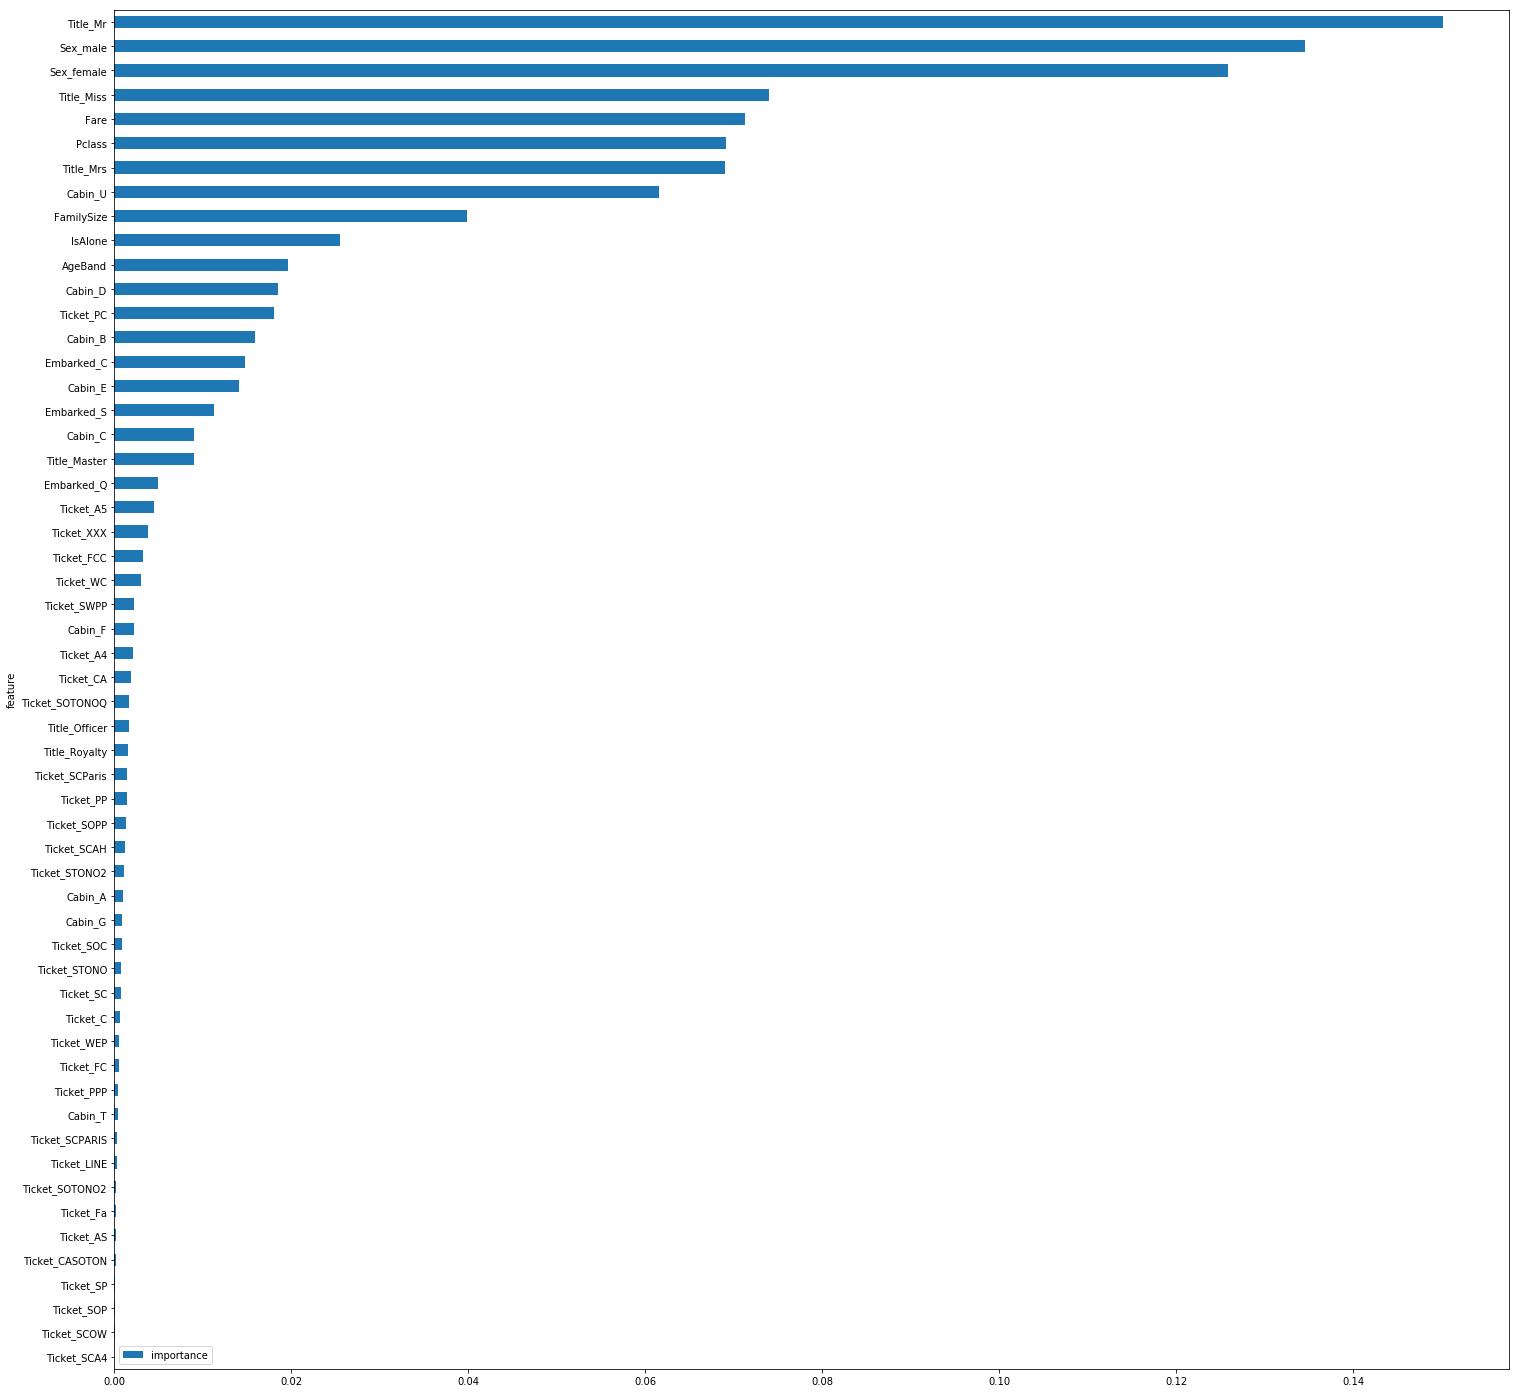

In [4]:
random_state = 42
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]
y = train_df['Survived']
train_df.drop(['Survived'], axis=1, inplace=True)
test_ids = test_df['PassengerId']
print('shapes2', train_df.shape, test_df.shape)
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Jonkheer', 'Don', 'Sir', 'Countess', 'Lady', 'Dona'], 'Royalty')
    dataset['Title'] = dataset['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer')
    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace(['Mme'], 'Mrs')
#     dataset['Title'] = dataset['Title'].astype('category')
#     dataset['Title'] = dataset['Title'].cat.codes

combined = pd.concat([train_df, test_df])
grouped_median_age = combined[train_df.Age.notnull()].groupby(['Sex', 'Pclass', 'Title']).median()
grouped_median_age = grouped_median_age.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
grouped_median_age

def assign_age(row):
    condition = (
        (grouped_median_age['Sex'] == row['Sex']) & 
        (grouped_median_age['Title'] == row['Title']) & 
        (grouped_median_age['Pclass'] == row['Pclass'])
    )
    return grouped_median_age[condition]['Age'].values[0]

for dataset in combine:
    dataset['Age'] = dataset.apply(lambda row: assign_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    dataset.loc[dataset.Embarked.isnull(), 'Embarked'] = 'S'
    dataset.loc[dataset.Cabin.notnull(), 'Cabin'] = dataset.loc[dataset.Cabin.notnull(), 'Cabin'].map(lambda x: x[0])
    dataset.loc[dataset.Cabin.isnull(), 'Cabin'] = 'U' #unknown
    
print('shapes1', train_df.shape, test_df.shape)
    
def cleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'AgeBand'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'AgeBand'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'AgeBand'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'AgeBand'] = 3
    dataset.loc[ dataset['Age'] > 64, 'AgeBand'] = 4
    dataset['AgeBand'] = dataset['AgeBand'].astype(int)
    dataset.loc[dataset['Fare'].isnull(), 'Fare'] = 8
#     dataset.loc[dataset['Fare'] <= 8, 'FareBand'] = 0
#     dataset.loc[(dataset['Fare'] > 8) & (dataset['Fare'] <= 14.454), 'FareBand'] = 1
#     dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'FareBand']   = 2
#     dataset.loc[ dataset['Fare'] > 31, 'FareBand'] = 3
#     dataset['FareBand'] = dataset['FareBand'].astype(int)
    dataset['Ticket'] = dataset['Ticket'].map(cleanTicket)
#     for column in ['Ticket']:
#         dataset[column] = dataset[column].astype('category')
#         dataset[column] = dataset[column].cat.codes
print('shapes4', train_df.shape, test_df.shape)
for dataset in combine:
#     dataset.drop(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'FamilySize'], axis=1, inplace=True)
    dataset.drop(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch'], axis=1, inplace=True)
print('shapes5', train_df.shape, test_df.shape)
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)
# Get missing columns in the training test
missing_cols = set( train_df.columns ) - set( test_df.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_df[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_df = test_df[train_df.columns]
print('shapes', train_df.shape, test_df.shape)

print(train_df.head())
## array([0.81564246, 0.80446927, 0.80898876, 0.79213483, 0.8079096 ])
# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, min_samples_leaf=100, max_depth=2, random_state=random_state)

## array([0.79888268, 0.81564246, 0.81460674, 0.80337079, 0.85875706])
clf = RandomForestClassifier(max_depth=4, max_features=3, n_estimators=400)

## array([0.75977654, 0.75977654, 0.7752809 , 0.76966292, 0.82485876])
# clf = VotingClassifier(
#     estimators=[
#         ('lr', LogisticRegression()),
#         ('svc', SVC()),
#         ('tree', DecisionTreeClassifier(max_depth=2, max_features=3)),
#         ('sgd', SGDClassifier()),
#         ('linear_svc', LinearSVC()),
#         ('gaussian', GaussianNB()),
#         ('knn', KNeighborsClassifier(n_neighbors = 2))
#     ],
#     voting='hard',
# )

## array([0.82122905, 0.80446927, 0.79775281, 0.75842697, 0.8079096 ])
# clf = AdaBoostClassifier(
#     DecisionTreeClassifier(max_depth=1), n_estimators=300,
#     algorithm='SAMME', learning_rate=0.2
# )

# clf = DecisionTreeClassifier()
# cv = cross_val_score(clf, train_df, y, cv=5)
# print(cv)
clf.fit(train_df, y)
# print("*"*40, "running grid search")
# param_test = {'n_estimators': np.linspace(100,500,5, dtype=np.int),
#               'max_depth': [1,2,3,4,6,8],
#               'max_features': ['sqrt', 'auto', 'log2'],
#               'min_samples_split': [2, 3, 10],
#               'min_samples_leaf': [1, 3, 10],
#               'bootstrap': [True, False],
#              }
# gs = GridSearchCV(estimator=clf, param_grid=param_test, cv=5, n_jobs=5, verbose=1)
# gs.fit(train_df, y)
# print("*"*40, "best params", gs.best_params_, gs.best_score_)
# clf.fit(train_df, y)
cv = cross_val_score(clf, train_df, y, cv=5)
print(cv)
features = pd.DataFrame()
features['feature'] = train_df.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(25, 25))
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train_df)
test_reduced = model.transform(test_df)
print("reduced shape", train_reduced.shape, test_reduced.shape)
print("*** retrain after reducing***")
print(cross_val_score(clf, train_reduced, y, cv=5))
clf.fit(train_reduced, y)
logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, logreg_cv, rf, gboost]
for m in models:
    print('Cross-validation of : {0}'.format(m.__class__))
    score = np.mean(cross_val_score(m, X=train_reduced, y=y, scoring='accuracy', cv=5))
    print('CV score = {0}'.format(score))
    print('*'*10)

In [11]:
print("*"*40, "running grid search")
param_test = {'n_estimators': np.linspace(100,500,5, dtype=np.int),
              'max_depth': [1,2,3,4,6,8],
              'max_features': ['sqrt', 'auto', 'log2'],
              'min_samples_split': [2, 3, 10],
              'min_samples_leaf': [1, 3, 10],
              'bootstrap': [True, False],
             }
gs = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_test, cv=5, n_jobs=5, verbose=1)
gs.fit(train_reduced, y)
print("*"*40, "best params", gs.best_params_, gs.best_score_)

**************************************** running grid search
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   30.4s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed:  6.9min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed:  9.1min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 11.7min
[Parallel(n_jobs=5)]: Done 4990 tasks      | elapsed: 14.3min
[Parallel(n_jobs=5)]: Done 6040 tasks      | elapsed: 17.2min
[Parallel(n_jobs=5)]: Done 7190 tasks      | elapsed: 20.5min


**************************************** best params {'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 100, 'bootstrap': True, 'min_samples_split': 3, 'max_features': 'auto'} 0.835016835016835


[Parallel(n_jobs=5)]: Done 8100 out of 8100 | elapsed: 23.4min finished


In [5]:
param_test = {
    'learning_rate': np.linspace(0.1, 0.5, 5),
    'n_estimators': np.linspace(100, 1000, 9, dtype=np.int),
    'max_depth': np.linspace(1, 5, 5, dtype=np.int),
    'min_samples_split': [2,5,10,20],
    'max_features': [2,4,6,8]
}
gs = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_test, cv=5, n_jobs=5, verbose=1)
gs.fit(train_reduced, y)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


[Parallel(n_jobs=5)]: Done  91 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done 241 tasks      | elapsed:   24.0s
[Parallel(n_jobs=5)]: Done 491 tasks      | elapsed:   48.4s
[Parallel(n_jobs=5)]: Done 841 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 1291 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 1841 tasks      | elapsed:  3.8min
[Parallel(n_jobs=5)]: Done 2491 tasks      | elapsed:  5.9min
[Parallel(n_jobs=5)]: Done 3241 tasks      | elapsed:  9.0min
[Parallel(n_jobs=5)]: Done 4091 tasks      | elapsed: 11.6min
[Parallel(n_jobs=5)]: Done 5041 tasks      | elapsed: 13.5min
[Parallel(n_jobs=5)]: Done 6091 tasks      | elapsed: 16.6min
[Parallel(n_jobs=5)]: Done 7241 tasks      | elapsed: 21.7min
[Parallel(n_jobs=5)]: Done 8491 tasks      | elapsed: 23.9min
[Parallel(n_jobs=5)]: Done 9841 tasks      | elapsed: 27.9min
[Parallel(n_jobs=5)]: Done 11291 tasks      | elapsed: 33.1min
[Parallel(n_jobs=5)]: Done 12841 tasks      | elapsed: 36.5min
[Parallel(

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=5,
       param_grid={'max_depth': array([1, 2, 3, 4, 5]), 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5]), 'min_samples_split': [2, 5, 10, 20], 'n_estimators': array([ 100,  212,  325,  437,  550,  662,  775,  887, 1000]), 'max_features': [2, 4, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [6]:
gs.best_params_, gs.best_score_

({'learning_rate': 0.5,
  'max_depth': 2,
  'max_features': 2,
  'min_samples_split': 2,
  'n_estimators': 437},
 0.8439955106621774)

In [18]:
best_forest = RandomForestClassifier(**{'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 100, 'bootstrap': True, 'min_samples_split': 3, 'max_features': 'auto'})
print(cross_val_score(best_forest, train_reduced, y, cv=5))
best_forest.fit(train_reduced, y)

[0.83240223 0.78212291 0.85955056 0.79775281 0.84180791]


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
best_forest = RandomForestClassifier(
    n_estimators=300, 
    max_depth= 6,
    min_samples_leaf= 1,
    max_features='sqrt',
    bootstrap=False,
    min_samples_split=2)
cross_val_score(best_forest, train_reduced, y, cv=5)

array([0.83798883, 0.81564246, 0.83707865, 0.78651685, 0.84180791])

In [9]:
gradient_boosting = GradientBoostingClassifier(
    learning_rate=0.5,
    n_estimators=437, 
    max_depth= 2,
    min_samples_leaf= 2,
    min_samples_split=2)
cross_val_score(gradient_boosting, train_reduced, y, cv=5)

array([0.83798883, 0.77094972, 0.79775281, 0.83146067, 0.8079096 ])

In [391]:
best_forest.fit(train_reduced, y)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
y_pred = best_forest.predict(test_reduced)
submission = pd.DataFrame({
    "PassengerId": test_ids,
    "Survived": y_pred
})
submission.to_csv('titanic_result_feature_engineer_reduced_best_forest.csv', index=False)

In [16]:
! kaggle competitions submit titanic -f titanic_result_feature_engineer_reduced_best_forest.csv -m "some extensive feature engineer"

Successfully submitted to Titanic: Machine Learning from Disaster